# Exercise 5: Parameter Inference in ODEs

In this exercise you will perform parameter inference as presented in the lecture, to learn a parametric contact rate in an epidemiological SIRD model that fits real-world COVID case counts from Germany.
The SIRD model is defined as follows:
\begin{align}
\dot{S}(t) &= - \frac{1}{N} \beta(t) S(t) I(t) \\
\dot{I}(t) &= \frac{1}{N} \beta(t) S(t) I(t) - \gamma I(t) - \eta I(t) \\
\dot{R}(t) &= \gamma I(t) \\
\dot{D}(t) &= \eta I(t).
\end{align}
In the lecture we learned how to do parameter inference in ODEs in general; here, we will define parametric models for $\beta_\theta(t)$ and then learn the parameters $\theta$ as explained in the lecture.

Goals here include:
- learning how to actually do parameter inference in code
- getting a feeling for how easy or hard the resulting optimization problem can be; and getting more insight into how to solve such optimization problems (choice of optimizer, loss function, ...)
- trying out different parametric models (and in particular, neural networks might be general, but there might be other models that might be more appropriate for this task)

## 0. Setting up the Julia environment

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate() # needed to set up the environment when running for the first time

  Activating project at `~/PhD-Projects/2022-23-numericsofml/03_Exercises/05_ODEs`


The following line installs the necessary packages;
feel free to comment it out once everything is installed!

In [2]:
#Pkg.add([
#    "Plots",
#    "UnPack",
#    "DataFrames",
#    "CSV",
#    "LaTeXStrings",
#    "OrdinaryDiffEq",
#    "Optimization",
#    "OptimizationOptimJL",
#    "OptimizationOptimisers",
#    "OptimizationFlux",
#    "Lux",
#    "NNlib",
#])

In [3]:
using Random, LinearAlgebra, Dates
using Plots, UnPack, DataFrames, CSV, LaTeXStrings
using OrdinaryDiffEq, Optimization, OptimizationOptimJL, OptimizationOptimisers
using Lux, NNlib, ComponentArrays

In [4]:
RNG = Xoshiro(1234)

Xoshiro(0x9951797c85a704f1, 0xb9d66be14dfba82b, 0xb170153285fd9556, 0xe90a07f7bdd1fd77, 0x9d4b5ee33e4bd661)

## 1. Getting the real-world data

Our goal is to fit the real-world COVID case counts from Germany.
This section downloads this data and creates some variables that will be needed below in the main part of the code.

You don't really need to edit anything in this section, simply run all the code.

In [5]:
if !isfile("population_2020.csv")
    UN_POPULATION_CSV_URL = "https://raw.githubusercontent.com/owid/covid-19-data/152b2236a32f889df3116c7121d9bb14ce2ff2a8/scripts/input/un/population_2020.csv"
    download(UN_POPULATION_CSV_URL, "population_2020.csv")
end

In [6]:
if !isfile("covid-19.csv")
    JHU_CSV_URL = "https://raw.githubusercontent.com/datasets/covid-19/main/data/countries-aggregated.csv"
    download(JHU_CSV_URL, "covid-19.csv")
end

In [7]:
df_population = CSV.read("population_2020.csv", DataFrame);
const N = df_population[df_population.entity.=="Germany", :].population[1]

83783945

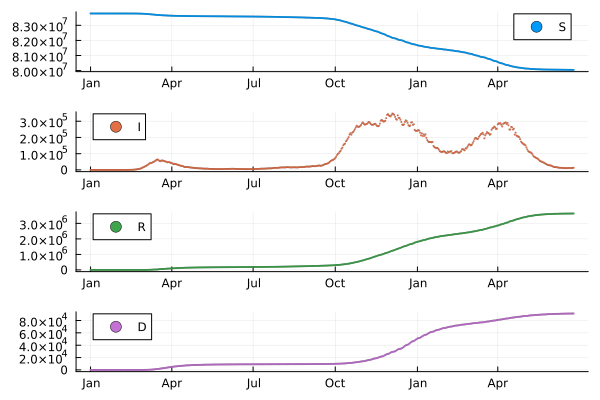

In [8]:
df = CSV.read("covid-19.csv", DataFrame);
df = df[df.Country.=="Germany", :]
# Tmax = 561
Tmax = 556 - 14
df = df[1:Tmax, :]

dates = df.Date
times = 1:length(df.Date)

D_data = df.Deaths
R_data = df.Recovered
I_data = df.Confirmed .- df.Recovered .- df.Deaths
S_data = N .- I_data .- R_data .- D_data

_data = [S_data'; I_data'; R_data'; D_data']

xticks = dates[begin]:Month(3):dates[end]
scatter(
    dates, _data', label=["S" "I" "R" "D"], color=[1 2 3 4], layout=(4, 1),
    markersize=1, markerstrokewidth=0.1,
    xticks=(xticks, Dates.monthabbr.(xticks)),
)

In [9]:
# maxima - could be useful for loss construction
Smax, Imax, Rmax, Dmax = maximum.((S_data, I_data, R_data, D_data))
_maxs = [Smax, Imax, Rmax, Dmax];

Let's assume we can only observe [I,R,D]:

In [10]:
H = [0 1 0 0; 0 0 1 0; 0 0 0 1]
data = H * _data
maxs = H * _maxs
;

## 2. Contact rate models

In this part you can define parametric models for the contact rate. 
The notebook includes a neural network approach with some (not very tuned) architecture choice, and piece-wise constant functions.
But the goal here is rather to show how to implement functions $\beta: \mathbb{R} \to \mathbb{R}$ in Julia code via some examples, so *do try out implementing your own model!*  
(e.g. polynomials, splines, a linear combination of handcrafted features; any function that maps `(t, parameters) -> \beta(t)` works!)

### 2.1. Neural network
This uses the [Lux.jl](http://lux.csail.mit.edu/stable/) package, which is particularly convenient in this context because it handles both inputs and parameters very explicitly: In Lux a neural network is a function `(input, parameters, state) -> output`; in many other packages, the latter two are handled implicitly. You should be able to just modify the code below, but if you want to learn more check out the [documentation](http://lux.csail.mit.edu/stable/).

**EDIT THE FOLLOWING CELL TO CHANGE THE NEURAL NETWORK ARCHITECTURE**  
(width, depth, other activations, skip connections or not, ...)

In [11]:
####################################################################################
# Change the NN architecture here
####################################################################################
NN_WIDTH = 3
NN_DEPTH = 5
# NN_ACTIVATION = NNlib.relu
NN_ACTIVATION = tanh
_β_nn = Lux.Chain(
    t -> t ./ Tmax,
    Lux.Dense(1, NN_WIDTH, NN_ACTIVATION),
    # The following was just a convenient way to handle depth
    [
        # Lux.Dense(NN_WIDTH, NN_WIDTH, NN_ACTIVATION)
        Lux.SkipConnection(Lux.Dense(NN_WIDTH, NN_WIDTH, NN_ACTIVATION), +)
        for _ in 1:(NN_DEPTH-1)
    ]...,
    Lux.Dense(NN_WIDTH, 1, sigmoid),
);

# This is how neural networks in Lux.jl are initialized:
nn_parameters, nn_state = Lux.setup(RNG, _β_nn)

# The following is needed for Optimization.jl to be able to handle the parameters
nn_parameters = ComponentArray(nn_parameters)

# Convenience function that directly maps (time, parameters) -> contact rate
β_nn(t, ps) = Lux.apply(_β_nn, [t], ps, nn_state)[1][1]

β_nn (generic function with 1 method)

The last `β_nn(t, ps)` is the actual important function with the desired type signature `(Real, Vector{Real}) -> Real` which will be used in the code below.

To get a feeling of the kind of model we just defined (which is not always easy in the neural network context), we can visualize the model by sampling initial parameters and plotting the resulting function:

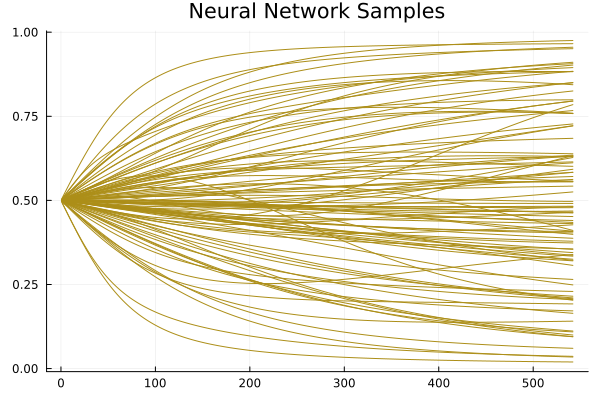

In [12]:
function plot_nn_prior(nn, RNG=RNG, N=100; kwargs...)
    p = plot(; kwargs...)
    for _ in 1:N
        ps, st = Lux.setup(RNG, nn)
        plot!(p, t -> Lux.apply(nn, [t], ps, nn_state)[1][1], times, label="", color=5)
    end
    return p
end

plot_nn_prior(_β_nn, title="Neural Network Samples")

### 2.2. Piece-wise constant functions
The following block defines another parametric model class: Piece-wise constant functions.
They might not be that great as models, but the simplicity of the code demonstrates how you can very easily implement your own idea for a contact rate model. 
So try things out!

In [13]:
number_of_steps = 24
step_parameters = randn(number_of_steps)
function β_step(t, p)
    #  Check which of the step functions applies to this t:
    idx = Int(ceil(number_of_steps * t / times[end]))

    return sigmoid(p[idx])
end


β_step (generic function with 1 method)

Again, let's can visualize the model we just defined:

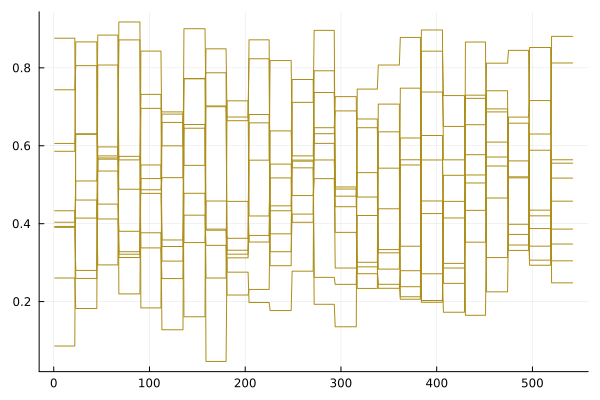

In [14]:
function plot_beta(β, RNG=RNG, N=100)
    p = plot()
    for _ in 1:N
        ps = randn(number_of_steps)
        plot!(p, t -> β_step(t, ps), times, label="", color=5)
    end
    display(p)
end
plot_beta(β_step, RNG, 10)

### 2.3. Your own contact rate model
Try something out!

In [15]:
####################################################################################
# Define your own contact rate model here if you want
####################################################################################
custom_parameters = randn(100)
function β_custom(t, p)
    return t
end

β_custom (generic function with 1 method)

### 2.4. Select the model 

**IF YOU WANT TO CHOOSE ANOTHER MODEL YOU NEED TO CHANGE THE FOLLOWING LINES**  
The variables `β` and `p` will be used below.

In [16]:
β, p = β_nn, nn_parameters
#β, p = β_step, step_parameters
#β, p = β_custom, custom_parameters
;

## 3. Defining the SIRD model

This part defines the SIRD ODE, by using the β defined above.  
**You do most likely not need to edit this section.** But be aware that is uses the `β` defined above so the cell neds to be re-run when the model is adjusted.

In [17]:
const I0 = 0.1
const γ = 0.06
const η = 0.002

function sird(u, p, t)
    S, I, R, D = u
    βt = β(t, p)
    dS = -βt * S * I / N
    dI = βt * S * I / N - γ * I - η * I
    dR = γ * I
    dD = η * I
    return [dS, dI, dR, dD]
end
u0 = [S_data[1]-I0, I_data[1]+I0, R_data[1], D_data[1]]
tspan = (1, length(df.Date))
prob = ODEProblem(sird, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: false
timespan: (1, 542)
u0: 4-element Vector{Float64}:
 8.37839449e7
 0.1
 0.0
 0.0

Simulating the dynamical system with the current parameters gives the following trajectory:

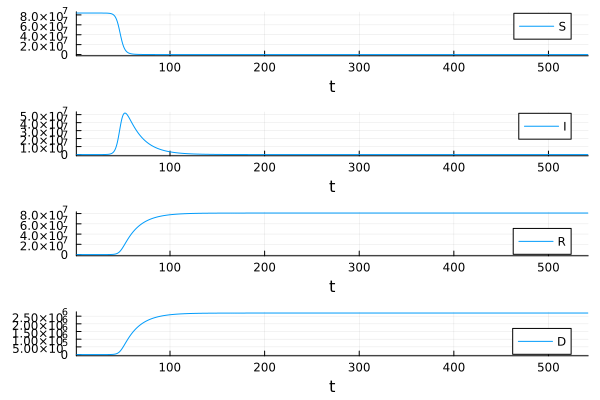

In [18]:
sol = solve(prob, Tsit5())
plot(sol, label=["S" "I" "R" "D"], layout=(4,1))

## 4. Defining the loss function
Here we define the loss function that needs to be optimized, as a function `(beta, _) -> loss` (the second argument is there in case the loss function has some parameters that we'd like to set but which are not optimized; since we don't, we just write `_` as a place holder).

**The loss function strongly influences the result of the optimization, so this is the second location that you can adjust to improve the results!**

In [19]:
function loss(p, _)

    sol = solve(
        prob, 
        Rosenbrock23(), # fast implicit RK solver; if things break, maybe try Tsit5()
        #Tsit5(),
        saveat=1, # this makes the solver solve at every integer t
        p=p,
        # abstol=1e-6, reltol=1e-9, # this way you can tweak tolerances
    )
    pred = Array(sol) 

    ####################################################################################
    # Define your loss here
    ####################################################################################
    # l = sum(abs2, (H*pred .- data)) # vanilla mean-square error
    l = sum(abs2, (H*pred .- data) ./ maxs) # motivation here: rescale the dimensions to adjust the scales
    # l = sum(abs2, log.(H*pred .+ 1) .- log.(data .+ 1)) # idea here: loss in log-space
    # l = ... # your try

    return l, sol
end

loss(p, nothing)[1]

980393.8037069119

## 5. Optimization

This is where the optimization itself happens.
We use the Optimization.jl package, which provides a convenient user interface to define optimization problems and provides a wide variety of solvers and options.

Let's first define the `OptimizationProblem`:

In [20]:
adtype = Optimization.AutoForwardDiff()
optfunc = Optimization.OptimizationFunction(loss, adtype)
optprob = Optimization.OptimizationProblem(optfunc, p);

We `solve` this problem in the next cell.
The notebook provides a default optimizer choice, but other optimizers might be much more appropriate to this problem. 
It might even be a good idea to solve the problem in two parts, by running a first-order method first and then fine-tune with a second-order solver!

**EDIT THE FOLLOWING CELLS TO CHANGE THE OPTIMIZER OR EVEN DO A TWO-PART OPTIMIZATION!**

In [21]:
res = Optimization.solve(
    optprob,
    #Adam(), # the de-facto default choice in the machine learning context
    # alternatives might be:
    # Adam(0.01),
    # Adam(0.001),
    # LBFGS(),
    # LBFGS(linesearch=Optim.LineSearches.BackTracking()),
    BFGS(initial_stepnorm=0.1), # this one tends to work quite well ;)
    # or others!
    maxiters=100,
)

retcode: Failure
u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[0.56987935; -0.561058; -0.38479105;;], bias = Float32[-0.371495; -0.38535827; 0.54411054;;]), layer_3 = (weight = Float32[0.5405517 0.80775833 -0.3209272; -0.6973238 0.084300175 -0.09394749; 0.5047563 -0.30414125 -0.66053444], bias = Float32[-0.5028062; 0.22505276; 1.0671493;;]), layer_4 = (weight = Float32[-0.84735906 0.026832016 0.9581563; 0.48937815 0.7331999 0.2085258; -0.25585783 0.44832113 0.7765517], bias = Float32[-0.5909085; -0.15256059; 0.96656233;;]), layer_5 = (weight = Float32[0.5312903 -0.6227295 0.73287135; -1.0114483 0.6737339 0.34121683; -0.6117922 -0.24928203 -0.72105473], bias = Float32[0.42829603; 0.13956605; 1.4837754;;]), layer_6 = (weight = Float32[0.55827236 1.0131849 -0.05749966; 0.28999 0.7682247 -0.7640937; 0.6177053 0.39301556 0.49214226], bias = Float32[-0.017331982; -0.14615451; 0.92127776;;]), layer_7 = (weight = Float32[0.23068276 0.6280541 -0.2184052], bias = F

In [22]:
#res2 = Optimization.solve(
#     remake(optprob, u0=res.u),
#     LBFGS(),
#     #LBFGS(linesearch=Optim.LineSearches.BackTracking()),
#     #BFGS(initial_stepnorm=0.1),
#     callback=callback(),
#     maxiters=10)

## 6. Visualize the result

You did it! By solving the optimization problem you did parameter inference in ODEs, and if things worked well then you now have a parametric contact-rate model that fits the real-world COVID case counts!
But of course things can also go wrong: The optimization might not converge or converge to a local optimum, your model choice might not be flexible enough, or you might even just have a subtle bug somewhere. So, visually check the result:

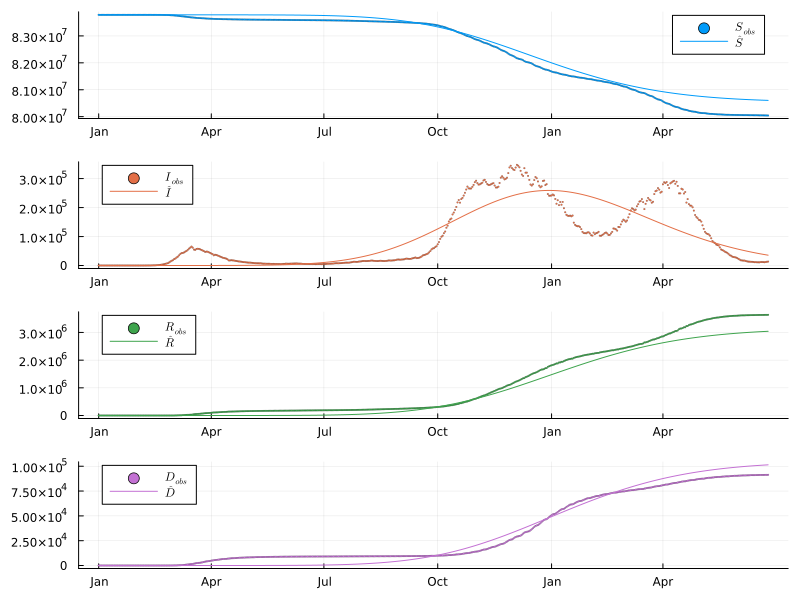

In [23]:
sol = solve(prob, Rosenbrock23(), p=res.u, saveat=1)
p1 = plot(xlabel="", layout=(4,1))
scatter!(p1, dates, _data',
    color=[1 2 3 4],
    label=[L"S_{obs}" L"I_{obs}" L"R_{obs}" L"D_{obs}"],
    markersize=1, markerstrokewidth=0.1,
)
plot!(p1, dates, Array(sol)',
    color=[1 2 3 4], 
    label=[L"\hat{S}" L"\hat{I}" L"\hat{R}" L"\hat{D}"],
)
xticks = dates[begin]:Month(3):dates[end]
plot!(p1, xticks=(xticks, Dates.monthabbr.(xticks)), size=(800, 600))

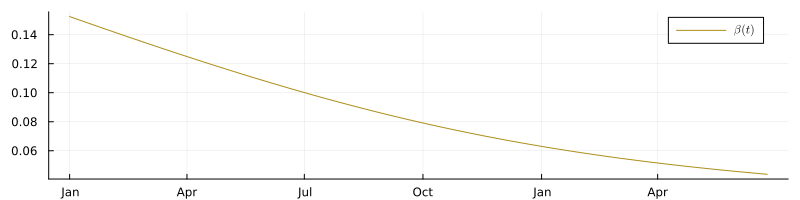

In [24]:
betas = (t -> β(t, res.u)).(times)
p2 = plot(dates, betas, label=L"\beta(t)", color=5)
plot!(p2, xticks=(xticks, Dates.monthabbr.(xticks)), size=(800, 200))

## 7. Questions

Elaborate a bit on your results:
- How does the result look? Are you satisfied with the fit? 
- What went well, what went wrong? 
- How could the result be improved? Any potential future steps?

# More resources
- julia documentation: https://docs.julialang.org/en/v1/
- Lux.jl for neural networks: http://lux.csail.mit.edu/stable/
- Optimization.jl documentation: https://optimization.sciml.ai/stable/
- (Not used but related) DiffEqFlux.jl: https://diffeqflux.sciml.ai/stable/